In [1]:
# ============================
# ASL DNN vs NLLS COMPARISON
# Supervised NN (Mastropietro-style)
# ============================

import os
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from natsort import natsorted
from tqdm import tqdm

In [2]:
BASE_DIR = "/home/labadmin/Desktop/ashtami/Multipld_project/sctimple/sctdata"

perf_folders = ["perf_1525", "perf_2025", "perf_2525", "perf_3025"]
M0_folders   = ["M0_1525",  "M0_2025",  "M0_2525",  "M0_3025"]
mask_folder  = os.path.join(BASE_DIR, "brain_mask")

OUTPUT_DIR = os.path.join(BASE_DIR, "NN_ASL_Output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
PLDs = np.array([1.525, 2.025, 2.525, 3.025])
tau = 1.8
T1b = 1.65
R1a = 1 / T1b
alpha = 0.85
lmbda = 0.9
eps = 1e-12

In [4]:
def load_dicom_volume(folder):
    files = natsorted([os.path.join(folder, f) for f in os.listdir(folder)])
    slices = [pydicom.dcmread(f) for f in files]
    slices.sort(key=lambda s: int(s.InstanceNumber))
    vol = np.stack([s.pixel_array for s in slices], axis=-1).astype(np.float32)

    px, py = map(float, slices[0].PixelSpacing)
    thk = float(slices[0].SliceThickness)
    affine = np.diag([px, py, thk, 1])
    return vol, affine

In [5]:
def buxton_signal(plds, f, att):
    f_scaled = (2 * alpha * f) / R1a
    s = np.zeros_like(plds)

    for i, t in enumerate(plds):
        if t < att:
            s[i] = 0
        elif t < att + tau:
            s[i] = f_scaled * np.exp(-att * R1a) * (1 - np.exp(-(t - att) * R1a))
        else:
            s[i] = f_scaled * np.exp(-att * R1a) * (1 - np.exp(-tau * R1a)) * \
                   np.exp(-(t - att - tau) * R1a)
    return s

In [6]:
def generate_training_data(N=300_000):
    X, Y = [], []

    for _ in tqdm(range(N), desc="Simulating ASL signals"):
        cbf_ml = np.random.uniform(20, 90)
        att = np.random.uniform(0.5, 3.0)
        f = cbf_ml / (6000 * lmbda)

        sig = buxton_signal(PLDs, f, att)
        sig += np.random.normal(0, 0.02 * np.max(sig), sig.shape)

        X.append(sig)
        Y.append([cbf_ml, att])

    return np.array(X), np.array(Y)

In [7]:
class ASLNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
X, Y = generate_training_data()

y_scaler = StandardScaler()
Y_std = y_scaler.fit_transform(Y)

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        torch.tensor(Y_std, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=512, shuffle=True)

model = ASLNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(40):
    total = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch+1}: loss = {total/len(loader):.5f}")

Simulating ASL signals: 100%|█| 300000/300000 [00:03<00:00, 976


Epoch 1: loss = 0.65725
Epoch 2: loss = 0.52848
Epoch 3: loss = 0.35520
Epoch 4: loss = 0.24552
Epoch 5: loss = 0.19657
Epoch 6: loss = 0.16684
Epoch 7: loss = 0.14766
Epoch 8: loss = 0.13660
Epoch 9: loss = 0.13039
Epoch 10: loss = 0.12282
Epoch 11: loss = 0.12221
Epoch 12: loss = 0.11542
Epoch 13: loss = 0.11354
Epoch 14: loss = 0.11296
Epoch 15: loss = 0.11054
Epoch 16: loss = 0.10969
Epoch 17: loss = 0.10637
Epoch 18: loss = 0.10819
Epoch 19: loss = 0.10027
Epoch 20: loss = 0.10426
Epoch 21: loss = 0.10338
Epoch 22: loss = 0.10066
Epoch 23: loss = 0.10054
Epoch 24: loss = 0.09751
Epoch 25: loss = 0.09815
Epoch 26: loss = 0.09835
Epoch 27: loss = 0.09638
Epoch 28: loss = 0.09440
Epoch 29: loss = 0.09631
Epoch 30: loss = 0.09492
Epoch 31: loss = 0.09408
Epoch 32: loss = 0.09316
Epoch 33: loss = 0.09327
Epoch 34: loss = 0.09411
Epoch 35: loss = 0.09352
Epoch 36: loss = 0.09308
Epoch 37: loss = 0.09342
Epoch 38: loss = 0.09300
Epoch 39: loss = 0.09289
Epoch 40: loss = 0.09120


In [9]:
mask_vol, affine = load_dicom_volume(mask_folder)
mask = mask_vol > 0
sz = mask.shape

deltaM = np.zeros((*sz, 4))
M0 = np.zeros((*sz, 4))

for i in range(4):
    deltaM[..., i], _ = load_dicom_volume(os.path.join(BASE_DIR, perf_folders[i]))
    M0[..., i], _ = load_dicom_volume(os.path.join(BASE_DIR, M0_folders[i]))

In [10]:
print("BASE_DIR =", BASE_DIR)
print("\nContents of BASE_DIR:")
for item in os.listdir(BASE_DIR):
    print(" -", item)

BASE_DIR = /home/labadmin/Desktop/ashtami/Multipld_project/sctimple/sctdata

Contents of BASE_DIR:
 - perf_1525
 - M0_2025
 - perf_3025
 - M0_3025
 - NN_ASL_Output
 - brain_mask_new.m
 - M0_2525
 - perf_2025
 - brain_mask
 - IM47
 - M0_1525
 - perf_2525


In [11]:
CBF = np.full(sz, np.nan)
ATT = np.full(sz, np.nan)

model.eval()
with torch.no_grad():
    for x in tqdm(range(sz[0]), desc="NN inference"):
        for y in range(sz[1]):
            for z in range(sz[2]):
                if not mask[x,y,z]:
                    continue

                dm = deltaM[x,y,z,:] / 100
                m0 = np.mean(M0[x,y,z,:])

                if m0 <= 500:
                    continue

                inp = torch.tensor(dm / (m0 + eps), dtype=torch.float32).unsqueeze(0)
                pred_std = model(inp)
                pred = y_scaler.inverse_transform(pred_std.numpy())

                CBF[x,y,z] = pred[0,0]
                ATT[x,y,z] = pred[0,1]

NN inference: 100%|██████████| 128/128 [00:14<00:00,  8.80it/s]


In [12]:
CBF_nii = nib.Nifti1Image(CBF.astype(np.float32), affine)
ATT_nii = nib.Nifti1Image(ATT.astype(np.float32), affine)

nib.save(CBF_nii, os.path.join(OUTPUT_DIR, "CBF_DNN_ml_100g_min.nii.gz"))
nib.save(ATT_nii, os.path.join(OUTPUT_DIR, "ATT_DNN_sec.nii.gz"))

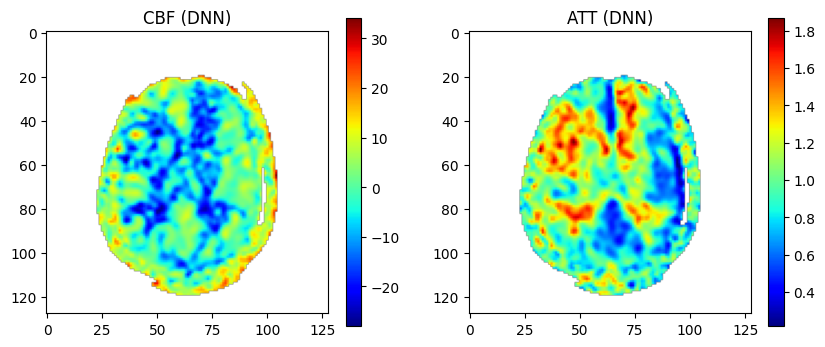

In [13]:
z = sz[2] // 2

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(CBF[:,:,z], cmap="jet")
plt.title("CBF (DNN)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(ATT[:,:,z], cmap="jet")
plt.title("ATT (DNN)")
plt.colorbar()
plt.show()